In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

## Чтение данных

In [2]:
df = pd.read_csv('data.csv', sep=';')
df.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,63,0,0,1,0,...,0,0,0,0.0,7000,4000,7526.3157,12000,0.583333,0
1,2,0,0,0,1809,33,1,0,1,0,...,0,0,0,0.0,10000,1000,8393.4426,30000,0.333333,0
2,3,0,0,0,1804,29,0,1,0,0,...,0,0,0,0.0,3000,1000,3425.9259,15000,0.200000,0
3,4,0,0,0,1560,28,1,1,0,0,...,0,0,0,0.0,2000,1000,1946.6666,3000,0.666667,0
4,5,0,0,0,258,33,1,0,0,0,...,0,0,0,0.0,2000,2000,4444.4444,8000,0.250000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255820 entries, 0 to 255819
Columns: 126 entries, ID to target
dtypes: float64(21), int64(105)
memory usage: 245.9 MB


Датасет состоит из 255820 наблюдений и 125 признаков. Все признаки являются числовыми (может быть были категориальными, но уже обработаны)

## Пропущенные значения

In [4]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing > 0:
        print('{} - {}%'.format(col, pct_missing*100))

feature_102 - 14.774059885857243%
feature_103 - 14.774059885857243%
feature_104 - 14.774059885857243%
feature_105 - 14.774059885857243%
feature_106 - 16.37596747713236%


Так как в фичах 102-105 одинаковое кол-во пропущенных значений, смеем предположить, что они находятся в одних и тех же наблюдениях. Может быть там же находится и часть пропущенных значений 106 фичи. Проверим:

In [5]:
df['feature_102'].isnull().sum()

37795

Всего 37 795 пропущенных значений в 102 фиче. Выведем значения столбцов 102-106, которые соответсвуют пропущенным значениям 102 столбца, и посчитаем в них кол-во пропущенных значений.

In [6]:
df[['feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106']]\
    [df['feature_102'].isnull()].isna().sum()

feature_102    37795
feature_103    37795
feature_104    37795
feature_105    37795
feature_106    37795
dtype: int64

Предположение о том, что пропущенные значения соответсвуют одним и тем же наблюдениям подтвердилось. Удалим эти наблюдения.

In [7]:
data = df[df['feature_102'].notnull()]

Рассмотрим 106 фичу, чтобы понять, как обработать оставшиеся в ней пропущенные значения.

In [8]:
data['feature_106'].value_counts()

1.000000    47662
0.000000    16264
0.500000     1262
0.333333     1054
0.250000     1017
            ...  
0.134680        1
0.295265        1
0.025843        1
0.061360        1
0.255208        1
Name: feature_106, Length: 29915, dtype: int64

Заполним пропущенные значения в 106 фиче медианой:

In [9]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [10]:
data.columns[data.isnull().any()]

Index([], dtype='object')

Таким образом, обработаны все пропущенные значения.

## Обработка выбросов

<AxesSubplot:>

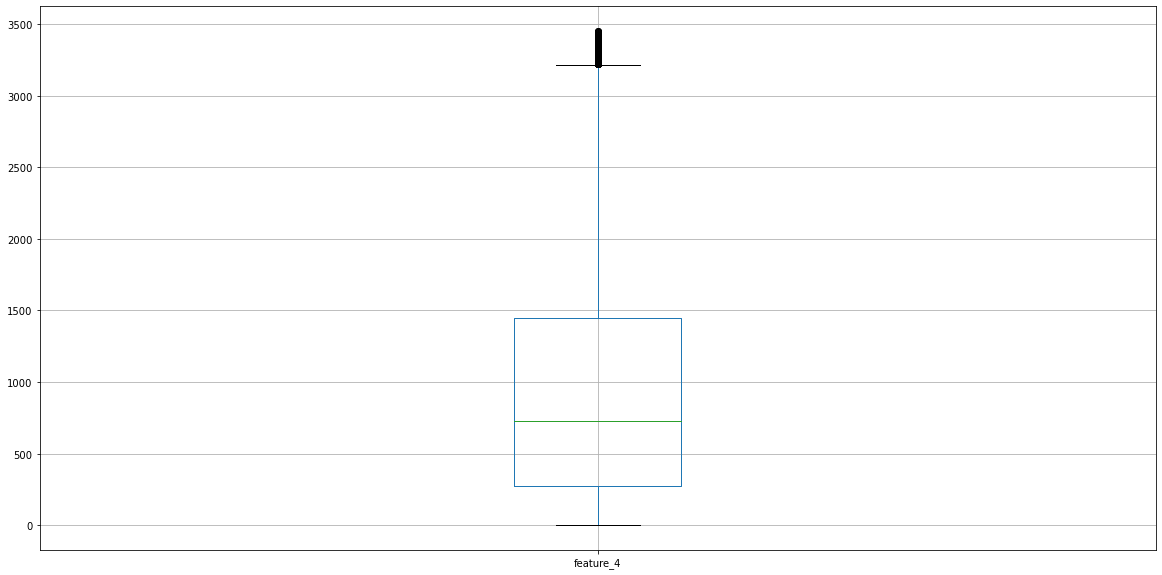

In [12]:
data.boxplot('feature_4')

In [13]:
Q1 = data['feature_4'].quantile(0.25)
Q3 = data['feature_4'].quantile(0.75)
IQR = Q3 - Q1
max_q = Q3+(1.5*IQR)

index_drop = data[data['feature_4']>max_q].index
data = data.drop(index_drop, axis=0)

## Анализ целевой переменной

In [14]:
data.target.value_counts()

0    181557
1     36124
Name: target, dtype: int64

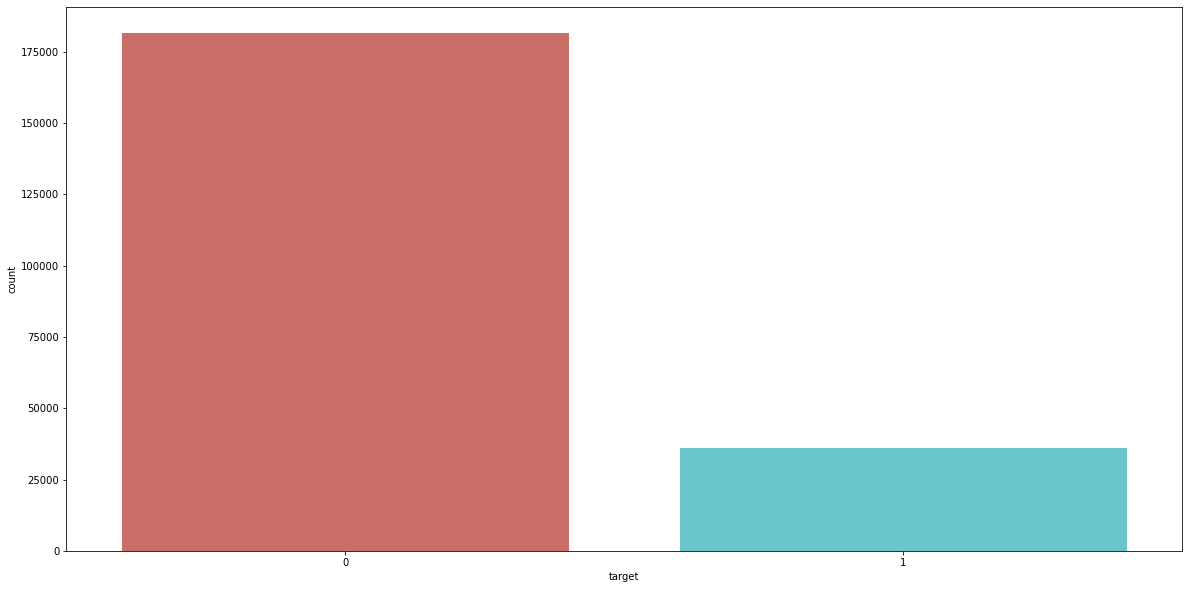

<Figure size 1440x720 with 0 Axes>

In [15]:
sns.countplot(x='target', data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [16]:
print(data[data.target == 0].shape[0]/data.shape[0])
print(data[data.target == 1].shape[0]/data.shape[0])

0.8340507439785741
0.16594925602142585


Классы не сбалансированы, соотношение классов 83:17

## Отбор признаков

In [17]:
corr_mat = data.corr()
corr_mat

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
ID,1.000000,0.005685,0.002459,-0.000301,0.002645,-0.001667,-0.002438,-0.000075,-0.002843,0.003763,...,-0.001407,-0.003676,-0.004174,-0.004279,0.001862,-0.000485,-0.000447,0.000010,0.002390,0.001583
feature_1,0.005685,1.000000,-0.003150,0.008337,-0.020553,-0.028683,0.025949,0.001722,0.000997,-0.002275,...,-0.061339,-0.038568,-0.038790,-0.034737,0.116977,0.113587,0.102654,0.043328,0.141738,0.109814
feature_2,0.002459,-0.003150,1.000000,-0.000167,0.004617,-0.002024,-0.001422,-0.000894,0.003257,-0.001118,...,-0.000542,-0.000741,-0.000623,-0.000503,-0.001866,-0.000485,0.000601,-0.001562,-0.000445,0.000968
feature_3,-0.000301,0.008337,-0.000167,1.000000,-0.040166,-0.031803,-0.003602,0.000012,0.002108,-0.010151,...,-0.003972,-0.006025,-0.004788,-0.001481,-0.001419,0.024402,-0.002692,-0.021400,0.036661,-0.005593
feature_4,0.002645,-0.020553,0.004617,-0.040166,1.000000,0.179316,0.035619,-0.122870,0.079838,0.042931,...,0.025673,0.062647,0.061125,-0.024619,-0.015571,-0.238327,-0.047307,0.189893,-0.286720,0.032837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_121,-0.000485,0.113587,-0.000485,0.024402,-0.238327,0.052527,0.077613,-0.050348,0.050978,0.002776,...,0.157090,0.142265,0.138641,0.301337,0.429859,1.000000,0.635523,0.251531,0.318195,0.069411
feature_122,-0.000447,0.102654,0.000601,-0.002692,-0.047307,-0.004363,0.109239,-0.068085,0.094025,-0.025643,...,0.261029,0.307668,0.305133,0.328712,0.755828,0.635523,1.000000,0.758593,0.176749,0.019240
feature_123,0.000010,0.043328,-0.001562,-0.021400,0.189893,-0.042156,0.092487,-0.065603,0.099203,-0.038737,...,0.330503,0.460193,0.423987,0.296462,0.675889,0.251531,0.758593,1.000000,-0.141326,-0.022211
feature_124,0.002390,0.141738,-0.000445,0.036661,-0.286720,0.009455,-0.011686,0.023634,-0.028352,0.009353,...,0.140832,0.035645,0.040690,0.074388,0.505563,0.318195,0.176749,-0.141326,1.000000,0.106386


In [18]:
feature_to_drop = [i for i in corr_mat if corr_mat[i].isnull().drop_duplicates().values[0]] 
feature_to_drop

['feature_51']

Заметим, что фича 51 - константная. Не будем её рассматривать.

In [19]:
data = data.drop(feature_to_drop, axis=1)

In [20]:
data_corr = data.drop(['target'], axis=1).corr()
corr_features = data_corr.where(np.triu(abs(data_corr) > 0.8, k=1)).stack()\
                .sort_values(ascending=False)
print(corr_features)

feature_111  feature_112    0.998817
feature_110  feature_114    0.982913
feature_13   feature_16     0.856110
feature_117  feature_118    0.840844
feature_103  feature_104    0.826401
feature_97   feature_100    0.811135
feature_91   feature_94     0.803648
feature_78   feature_80    -0.878814
dtype: float64


Видим, что многие признаки сильно коррелируют друг с другом. Посмотрим, какие признаки коррелируют с целевой переменной:

In [21]:
data_corr2 = corr_mat.iloc[:-1, -1]
data_corr2[abs(data_corr2)>0.2]

feature_83     0.212728
feature_110    0.211660
feature_114    0.216109
Name: target, dtype: float64

## Обучение модели

Разделим данные на признаки и целевую переменную:

In [22]:
X = data.drop(['target'], axis=1)
y = data.target

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_test, y_test оставим для тестирования модели. X_train и y_train будем использовать для валидации и обучения.

In [24]:
print('Кол-во объектов класса 0 в обучающей выборке: {}'.format(len(y_train[y_train==0])))
print('Кол-во объектов класса 1 в обучающей выборке: {}'.format(len(y_train[y_train==1])))

Кол-во объектов класса 0 в обучающей выборке: 127134
Кол-во объектов класса 1 в обучающей выборке: 25242


Не будем трогать несбалансированность классов, поскольку для нас важна вероятностная классификация.

In [25]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

y_train_pred = logisticRegr.predict(X_train)
y_test_pred = logisticRegr.predict(X_test)

Нас не интересует метрика accuracy, поскольку у нас несбалансированные классы. Посмотрим на визуальный образ confusion matrix:

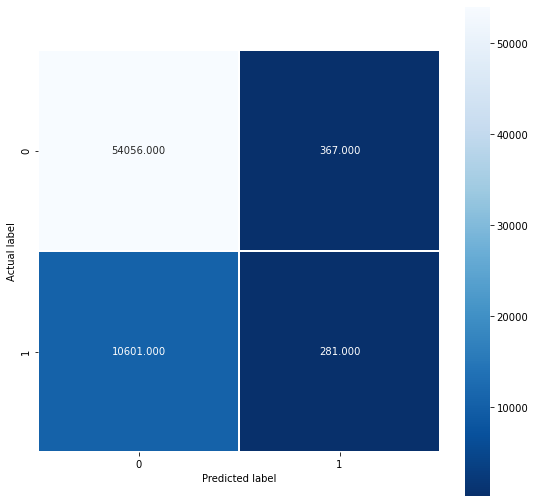

In [26]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

Будем максимизировать F1 меру, поскольку в задаче нет смыслового описания и следовательно непонятно, что важнее точность или полнота.

In [27]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     54423
           1       0.43      0.03      0.05     10882

    accuracy                           0.83     65305
   macro avg       0.63      0.51      0.48     65305
weighted avg       0.77      0.83      0.76     65305



In [28]:
print('f1_train - {}'.format(f1_score(y_train, y_train_pred)))
print('f1_test - {}'.format(f1_score(y_test, y_test_pred)))

f1_train - 0.046128500823723224
f1_test - 0.04874241110147442


Попробуем повысить значение F1 меры. Для начала с помощью кросс-валидации отыщем оптимальные параметры логистической регрессии:

In [29]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression()
parametrs = {'solver': ['newton-cg', 'sag', 'saga', 'liblinear', 'lbfgs'],
            'class_weight':['{0:0.83, 1:0.17}', 'balanced']}
grid_search_cv_clf = GridSearchCV(clf, n_jobs=-1, param_grid=parametrs, cv=5, scoring='f1')
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': ['{0:0.83, 1:0.17}', 'balanced'],
                         'solver': ['newton-cg', 'sag', 'saga', 'liblinear',
                                    'lbfgs']},
             scoring='f1')

In [30]:
best_param = grid_search_cv_clf.best_params_
best_param

{'class_weight': 'balanced', 'solver': 'newton-cg'}

In [31]:
best_clf = grid_search_cv_clf.best_estimator_

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

print('f1_train - {}'.format(f1_score(y_train, y_train_pred)))
print('f1_test - {}'.format(f1_score(y_test, y_test_pred)))

f1_train - 0.4390305510299448
f1_test - 0.43956748564600273


### Сделаем отбор признаков:

Попробуем повысить качество модели за счёт отбора признаков. Поделим тренировочную выборку на выборку для валидации - 30% и на обучение - 70%. Отберём 20 лучших признаков.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=20)
selector.fit(X_valid, y_valid)

col = selector.get_support(indices=True)
features_df_new = X_valid.iloc[:,col]
cols = features_df_new.columns.array
cols

<PandasArray>
[  'feature_1',   'feature_5',  'feature_28',  'feature_52',  'feature_54',
  'feature_55',  'feature_82',  'feature_83',  'feature_85',  'feature_86',
  'feature_87',  'feature_88',  'feature_96',  'feature_99', 'feature_102',
 'feature_104', 'feature_110', 'feature_113', 'feature_114', 'feature_124']
Length: 20, dtype: object

In [46]:
import statsmodels.api as sm
logit_model=sm.Logit(y_valid,X_valid[cols])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.404830
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.100     
Dependent Variable: target           AIC:              37051.9654
Date:               2021-11-25 09:47 BIC:              37226.5681
No. Observations:   45713            Log-Likelihood:   -18506.   
Df Model:           19               LL-Null:          -20560.   
Df Residuals:       45693            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
feature_1     0.0034    0.0382    0.0881  0.9298  -0.0716   0.0783
feature_5    -0.0138    0.0010  -13.7240  0.0000  -0.0158  -0.

Удалим их из рассмотрения признаки, для которых p-value > 0.05

In [47]:
for col in cols:
    try:
        print(col, corr_features[col])
    except:
        pass

feature_110 feature_114    0.982913
dtype: float64


Признаки 110 и 114 сильно коррелируют. Удалим один из них из рассмотрения.

In [48]:
cols = ['feature_5',  'feature_28',  'feature_52',  'feature_54',
    'feature_55',  'feature_82',  'feature_83',  'feature_85',  'feature_86',
    'feature_87',  'feature_88',  'feature_96',  'feature_99', 'feature_102', 
    'feature_113', 'feature_114', 'feature_124']

In [49]:
best_clf.fit(X_train[cols], y_train)

y_train_pred = best_clf.predict(X_train[cols])
y_test_pred = best_clf.predict(X_test[cols])

print('f1_train - {}'.format(f1_score(y_train, y_train_pred)))
print('f1_test - {}'.format(f1_score(y_test, y_test_pred)))

f1_train - 0.4254866234914221
f1_test - 0.42723538152259416


Отбор 20 лучших признаков ухудшил качество модели. Поварьируем число отобранных признаков:

In [68]:
scores_data = pd.DataFrame()

for count in range(10, 41):
    selector = SelectKBest(f_classif, k=count);
    selector.fit(X_valid, y_valid)

    col = selector.get_support(indices=True)
    features_df_new = X_valid.iloc[:,col]
    cols = features_df_new.columns.array
    
    best_clf.fit(X_train[cols], y_train);
    y_train_pred = best_clf.predict(X_train[cols])
    y_test_pred = best_clf.predict(X_test[cols])

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    
    temp_score_data = pd.DataFrame({'count_features':[count],
                                   'f1_train': [f1_train],
                                   'f1_test':[f1_test]})
    
    scores_data = scores_data.append(temp_score_data)

In [69]:
scores_data

,count_features,f1_train,f1_test
0,10,0.428011,0.428644
0,11,0.427368,0.427480
0,12,0.425669,0.427123
0,13,0.426312,0.427360
0,14,0.425701,0.427760
0,15,0.425750,0.428145
0,16,0.425933,0.428868
0,17,0.427839,0.429040
0,18,0.427798,0.429056
0,19,0.428069,0.429174


In [70]:
scores_data_long = pd.melt(scores_data, id_vars=['count_features'], value_vars=['f1_train', 'f1_test'],
                          var_name='set_type', value_name='score')
scores_data_long.head()

,count_features,set_type,score
0,10,f1_train,0.428011
1,11,f1_train,0.427368
2,12,f1_train,0.425669
3,13,f1_train,0.426312
4,14,f1_train,0.425701


<AxesSubplot:xlabel='count_features', ylabel='score'>

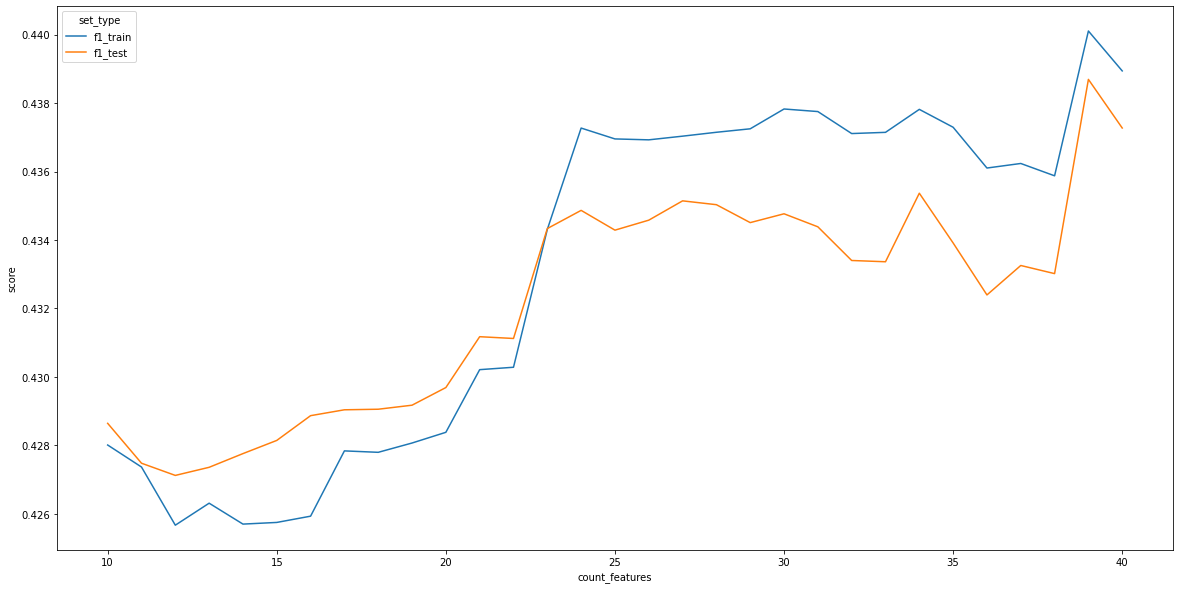

In [71]:
sns.lineplot(x='count_features', y='score', hue='set_type', data=scores_data_long)

Выберем кол-во признаков, на котором достигается максимум f меры:

In [72]:
count = int(scores_data.iloc[scores_data['f1_test'].argmax()]['count_features'])
count

39

In [78]:
selector = SelectKBest(f_classif, k=count)
selector.fit(X_valid, y_valid)

col = selector.get_support(indices=True)
features_df_new = X_valid.iloc[:,col]
cols = features_df_new.columns.array
cols

<PandasArray>
[  'feature_1',   'feature_5',   'feature_9',  'feature_28',  'feature_30',
  'feature_42',  'feature_48',  'feature_49',  'feature_52',  'feature_54',
  'feature_55',  'feature_82',  'feature_83',  'feature_85',  'feature_86',
  'feature_87',  'feature_88',  'feature_89',  'feature_91',  'feature_94',
  'feature_95',  'feature_96',  'feature_98',  'feature_99', 'feature_101',
 'feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106',
 'feature_108', 'feature_110', 'feature_113', 'feature_114', 'feature_115',
 'feature_116', 'feature_120', 'feature_121', 'feature_124']
Length: 39, dtype: object

In [85]:
best_clf.fit(X_train[cols], y_train)

y_train_pred = best_clf.predict(X_train[cols])
y_test_pred = best_clf.predict(X_test[cols])
y_test_pred_proba = best_clf.predict_proba(X_test[cols])

print('f1_train - {}'.format(f1_score(y_train, y_train_pred)))
print('f1_test - {}'.format(f1_score(y_test, y_test_pred)))

f1_train - 0.4401037415891325
f1_test - 0.43869042394452734


In [83]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     54423
           1       0.32      0.69      0.44     10882

    accuracy                           0.71     65305
   macro avg       0.62      0.70      0.62     65305
weighted avg       0.82      0.71      0.74     65305



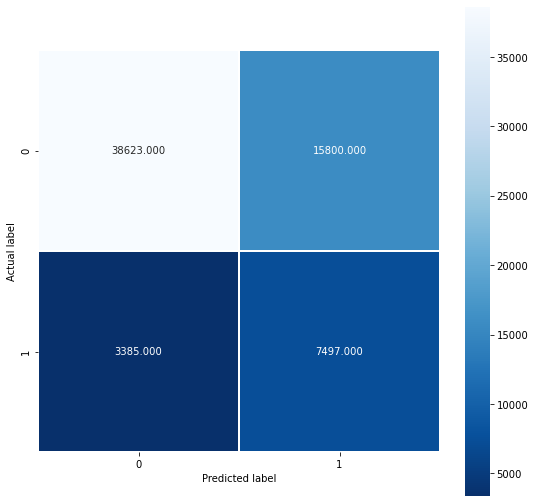

In [88]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

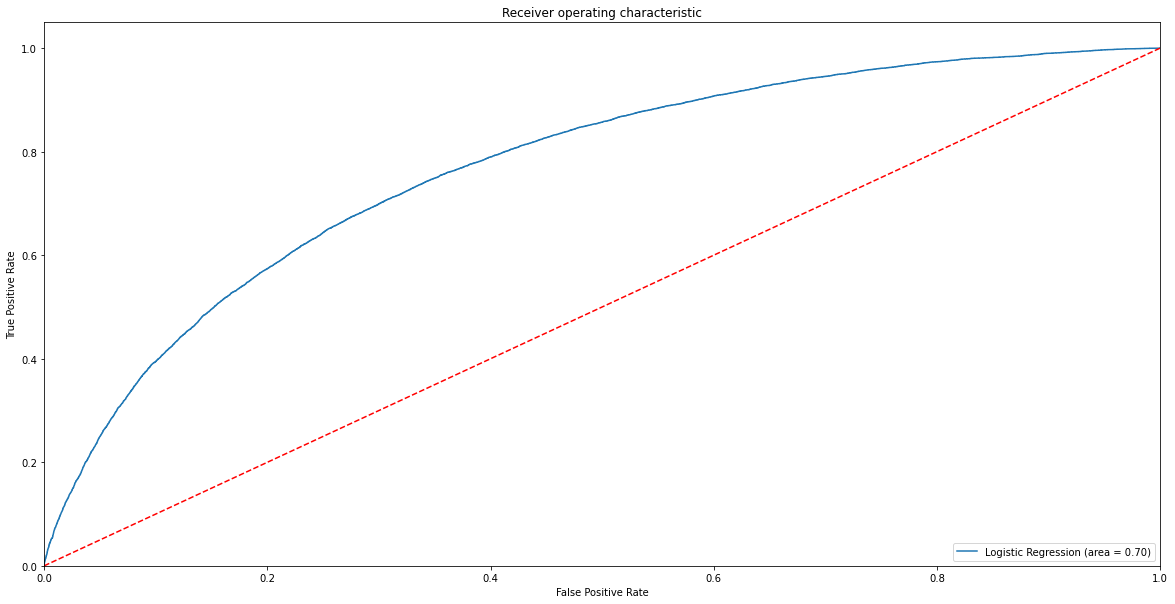

In [84]:
logit_roc_auc = roc_auc_score(y_test, best_clf.predict(X_test[cols]));
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test[cols])[:,1]);
plt.figure();
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc);
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Receiver operating characteristic');
plt.legend(loc="lower right");
plt.savefig('Log_ROC');
plt.show()

## Сводная таблица

In [86]:
final = pd.DataFrame(data=y_test)
final['predict'] = y_test_pred
final['predict_proba'] = y_test_pred_proba[:,1]

In [87]:
final.head()

,target,predict,predict_proba
227105,1,1,0.759918
23353,0,1,0.847194
225909,0,1,0.579499
213906,0,1,0.536905
236353,0,0,0.114290


In [89]:
final_data = pd.DataFrame()
i = 0
while i < 1:
    max_p = i+0.1
    proba = '({}, {})'.format(i, round(max_p, 1))
    group = final.query('predict_proba >= @i & predict_proba < @max_p').target.count()
    target = final.query('predict_proba >= @i & predict_proba < @max_p & target ==1').target.count()
    i = round(i + 0.1, 1)
    
    temp_data = pd.DataFrame({'Вероятность':[proba],
                              'Всего в группе':[group], 
                              'Кол-во target 1': [target]})
    
    final_data = final_data.append(temp_data)

In [90]:
final_data

,Вероятность,Всего в группе,Кол-во target 1
0,"(0, 0.1)",1073,11
0,"(0.1, 0.2)",7888,198
0,"(0.2, 0.3)",11193,593
0,"(0.3, 0.4)",10862,988
0,"(0.4, 0.5)",10992,1595
0,"(0.5, 0.6)",9494,2032
0,"(0.6, 0.7)",6096,1862
0,"(0.7, 0.8)",3514,1426
0,"(0.8, 0.9)",2580,1232
0,"(0.9, 1.0)",1613,945


## Работа модели на неразмеченных данных

In [91]:
verify_data = pd.read_csv('verify.csv', ';')
verify_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,34,0,1,0,0,...,1,0,0,0,0.0,6000,1000,4551.0204,12000,0.500000
1,255822,0,0,0,42,49,0,0,1,0,...,0,0,0,0,0.0,6000,3400,4700.0000,6000,1.000000
2,255823,0,0,0,265,69,0,1,0,0,...,0,0,0,0,0.0,3000,3000,4133.3333,6000,0.500000
3,255824,1,0,0,834,25,1,0,1,0,...,0,0,0,0,0.0,2000,1000,3875.0000,11000,0.181818
4,255825,0,0,0,772,26,1,1,0,0,...,1,0,0,0,0.0,8000,2000,7640.0000,12000,0.666667


In [92]:
for col in verify_data.columns:
    pct_missing = np.mean(verify_data[col].isnull())
    if pct_missing > 0:
        print('{} - {}%'.format(col, pct_missing*100))

feature_102 - 20.451543815812958%
feature_103 - 20.451543815812958%
feature_104 - 20.451543815812958%
feature_105 - 20.451543815812958%
feature_106 - 23.130465821881135%


In [93]:
verify_data.fillna(verify_data.median(axis = 0), axis=0 , inplace=True)

In [94]:
y_pred = best_clf.predict(verify_data[cols])
y_pred_proba = best_clf.predict_proba(verify_data[cols])

In [95]:
verify_data['score'] = y_pred_proba[:, 1]

In [96]:
verify_data[['ID', 'score']].to_csv('predict.csv', ';')

**Как можно заполнить пропущенные значения в данных?**
Можно заполнить их медианой, средним или модой. Или спрогнозировать с помощью kNN оценок

**Что делать, если таргет несбалансированный?**
Для начала нужно понять является ли несбалансированность проблемой для той задачи, которую мы решаем, и узнать, что нам важнее прогнозировать: вероятность принадлежности к классу или метку классу. Если метку класса, то можно воспользоваться алгоритмами для oversampling/undersampling (библиотеки SMOTE, NearMiss)

**Как бороться с переобучением?**
Регуляризация, увеличение объема данных, уменьшение кол-ва используемых признаков